In [22]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

from hidden_markov import hmm

In [2]:
# basic morse dictionary, we use '-' to mark word spaces 
alphabet = list('abcdefghijklmnopqrstuvwxyz-')
values = ['.-', '-...', '-.-.', '-..', '.', '..-.', '--.', '....', '..', '.---', '-.-', 
          '.-..', '--', '-.','---', '.--.', '--.-', 
          '.-.', '...', '-', '..-', '...-', '.--', '-..-', '-.--', '--..','-....-']

morse_dict = dict(zip(alphabet, values))
ascii_dict = dict(map(reversed, morse_dict.items())) # inverse mapping


In [3]:
# convert text to morse code
def morse_encode(text):
    return ' '.join([''.join(morse_dict.get(i, '')) for i in text.lower()])
 
# convert morse code to text
def morse_decode(code):
    return ''.join([ascii_dict.get(i, '') for i in code.split(' ')])


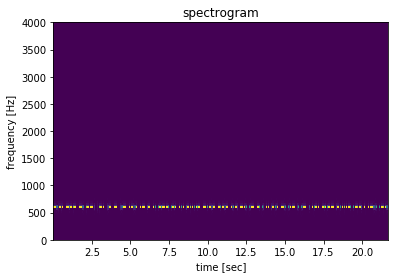

In [4]:
# read audio stream
fs, data = wavfile.read('morse.wav')

# spectral representation
f, t, S = signal.spectrogram(data, fs)

plt.figure(0) # spectrogram
plt.pcolormesh(t, f, S)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.title('spectrogram')
plt.show()



In [5]:
f_index = (500 < f) & (f < 700) # select frequency components closest to 600 Hz
f_index

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

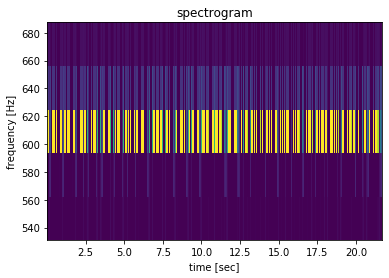

In [6]:
# spectrogram for selected frequency range
plt.figure(0) 
plt.pcolormesh(t, f[f_index], S[f_index,:])
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.title('spectrogram')
plt.show()

In [7]:
# convert to binary data
sum_vector = sum(S[f_index,:])
binary_data = np.zeros(len(sum_vector))
threshold = max(sum_vector)/2
for i in range(len(binary_data)):
    if sum_vector[i] > threshold:
        binary_data[i]=1

In [8]:
print(len(binary_data))
binary_data

775


array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0.

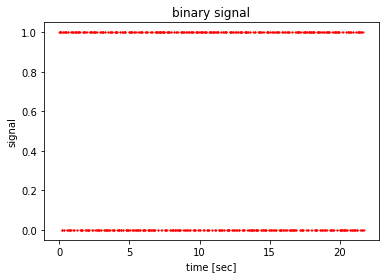

In [119]:
plt.figure(1)    # binary sequence
plt.plot(t,binary_data,'ro', markersize=1)
plt.ylabel('signal')
plt.xlabel('time [sec]')
plt.title('binary signal')
plt.show()

In [9]:
#==============================================================================
# states and symbols used 

# dot, dash, symbol space, character space, indifferent
states = ('.1','.2','-1','-2','-3','-4','-5','-6',' 1',' 2','_1','_2','_3','_4','_5','_6','x')
symbols = (True,False)

# morse symbols correspondig to states
state_values = ['.','','-','','','','','','','',' ','','','','','','']
state_dict = dict(zip(states, state_values))

# convert state sequence to morse symbols, remove trailing or leading spaces
def state_decode(sequence):
    return (''.join([''.join(state_dict.get(i, '')) for i in sequence])).strip()
 

In [10]:
#==============================================================================
# set up and run hidden markov model
    
# we assume that we do not start in the middle of a symbol
initial = np.matrix([
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
    ])

# state  .1 .2 -1 -2 -3 -4 -5 -6  1  2 _1 _2 _3 _4 _5 _6 x    
transition = np.matrix([
        [0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # .1 
        [0, 0.002, 0, 0, 0, 0, 0, 0, 0.498, 0, 0.498, 0, 0, 0, 0, 0, 0.02], # .2 nominal length
        [0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # -1
        [0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # -2
        [0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # -3
        [0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # -4
        [0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], # -5  
        [0, 0, 0, 0, 0, 0, 0, 0.002, 0.496, 0, 0.496, 0, 0, 0, 0, 0, 0.06], # -6 nominal length
        [0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0, 0, 0.02], #  1
        [0.498, 0, 0.498, 0, 0, 0, 0, 0, 0, 0.002, 0, 0, 0, 0, 0, 0, 0.02], #  2 nominal length
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0, 0.02], # _1
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0, 0.02], # _2
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0, 0.02], # _3
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0, 0.02], # _4
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.996, 0.02], # _5
        [0.498, 0, 0.498, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002, 0.02], # _6 nominal length
        [0.2, 0, 0.2, 0, 0, 0, 0, 0, 0.2, 0, 0.2, 0, 0, 0, 0, 0, 0.2]  # x  indifferent  
    ])

# emission probabilities
emission = np.matrix([
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], # emitting 'True'
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # emitting 'False'
    ]).transpose() 
  
    
# scale as probabilities, e.g. that components sum up to 1
initial = initial / np.sum(initial, axis=1).reshape((-1, 1))
transition = transition / np.sum(transition, axis=1).reshape((-1, 1))
emission = emission / np.sum(emission, axis=1).reshape((-1, 1))

# generate model
model = hmm(states, symbols, initial, transition, emission)

# run viterbi decoder
state_sequence = model.viterbi(binary_data)

result = morse_decode(state_decode(state_sequence))

print('Decoded string =>',result,'<=')

#==============================================================================



Decoded string => congratulations-you-did-very-well <=
